In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [12]:
sat = xr.open_dataset('/home/sh16450/Documents/repos/Antarctica_clouds/Charles/ON_MAR_GRID-CAL_LID_L2_BlowingSnow_Antarctica-Standard-V1-00-2006-06-2020-06_monthly_means.nc')['bs_freq']

mar = xr.open_dataset('/home/sh16450/Documents/repos/Antarctica_clouds/Charles/monthly-DSfreq-MAR_ERA5-2007-2020_new.nc')['bs_freq']

MAR_grid = xr.open_dataset(
    '/home/sh16450/code/MARcst-AN35km-176x148.cdf')


ds_grid = xr.Dataset({'RIGNOT': (['Y', 'X'], MAR_grid.RIGNOT.values),
                      'SH': (['Y', 'X'], MAR_grid.SH.values),
                      'LAT': (['Y', 'X'], MAR_grid.LAT.values),
                      'LON': (['Y', 'X'], MAR_grid.LON.values)},
                     coords={'X': (['X'], mar.X.values),
                             'Y': (['Y'], mar.Y.values)})

# MAR_grid.drop(['X', 'Y'])

# Add LAT LON to MAR data
mar['lat'] = ds_grid.LAT
mar['lon'] = ds_grid.LON
mar['RIGNOT'] = ds_grid.RIGNOT.where(ds_grid.RIGNOT > 0)
# MAR = MAR.drop_vars(['TIME_bnds'])
# MAR = MAR.rename({'TIME': 'time'})

# ==========================================================================
# CREATE the ICE MASK
# =========================================================

MAR_grid = xr.open_dataset(
    '/home/sh16450/code/MARcst-AN35km-176x148.cdf')
ds_grid = xr.Dataset({'RIGNOT': (['Y', 'X'], MAR_grid.RIGNOT.values),
                      'SH': (['Y', 'X'], MAR_grid.SH.values),
                      'LAT': (['Y', 'X'], MAR_grid.LAT.values),
                      'LON': (['Y', 'X'], MAR_grid.LON.values),
                      'ICE': (['Y', 'X'], MAR_grid.ICE.values),
                      'AIS': (['Y', 'X'], MAR_grid.AIS.values),
                      'SOL': (['Y', 'X'], MAR_grid.SOL.values),
                      'GROUND': (['Y', 'X'], MAR_grid.GROUND.values),
                      'AREA': (['Y', 'X'], MAR_grid.AREA.values),
                      'ROCK': (['Y', 'X'], MAR_grid.ROCK.values)},
                     coords={'X': (['X'], mar.X.values),
                             'Y': (['Y'], mar.Y.values)})

ais = ds_grid['AIS'].where(ds_grid)['AIS'] > 0  # Only AIS=1, other islands  =0
# Ice where ICE mask >= 30% (ICE[0-100%], dividing by 100 in the next ligne)
ice = ds_grid['ICE'].where(ds_grid['ICE'] > 30)
# Combine ais + ice/100 * factor area for taking into account the projection
ice_msk = (ais * ice * ds_grid['AREA'] / 100)

grd = ds_grid['GROUND'].where(ds_grid['GROUND'] > 30)
grd_msk = (ais * grd * ds_grid['AREA'] / 100)

lsm = (ds_grid['AIS'] < 1)
ground = (ds_grid['GROUND'] * ds_grid['AIS'] > 30)

shf = (ds_grid['ICE'] / ds_grid['ICE']).where((ds_grid['ICE'] > 30) &
                                              (ds_grid['GROUND'] < 50) & (ds_grid['ROCK'] < 30) & (ais > 0))
shelf = (shf > 0)

x2D, y2D = np.meshgrid(ds_grid['X'], ds_grid['Y'])
sh = ds_grid['SH']

dh = (ds_grid['X'].values[0] - ds_grid['X'].values[1]) / 2.


# ==========================================================


mar_grounded_mean = mar.where((ground == 1)&(mar.lat >= -81)).mean(dim='month')
sat_grounded_mean = sat.where((ground == 1)&(mar.lat >= -81)).mean(dim='month')

# Charles; way to plot the data
mar_grounded_mean = mar.where(ais == 1).mean(dim='month')
sat_grounded_mean = sat.where(ais == 1).mean(dim='month')



In [16]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
# mar_grounded_mean.plot(ax=axs[0], vmin=20, vmax=100)
# sat_grounded_mean.plot(ax=axs[1], vmin=20, vmax=100)

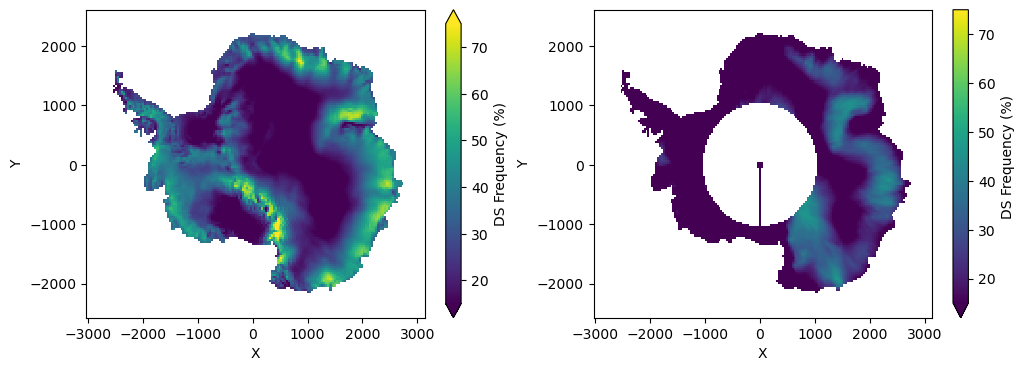

In [23]:
# Charles' way to plot the data

mar_grounded_mean = mar.where(ais == 1).mean(dim='month')
sat_grounded_mean = sat.where(ais == 1).mean(dim='month')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
mar_grounded_mean.plot(ax=axs[0], vmin=15, vmax=75, cbar_kwargs={'label': "DS Frequency (%)"})
sat_grounded_mean.plot(ax=axs[1], vmin=15, vmax=75, cbar_kwargs={'label': "DS Frequency (%)"})


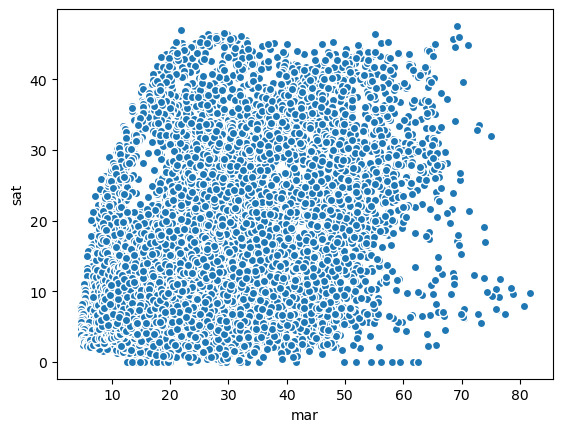

In [14]:
ds = xr.Dataset()
ds['mar'] = mar_grounded_mean
ds['sat'] = sat_grounded_mean
ds.plot.scatter(x='mar', y='sat')
